# Genetic Algorithms with DEAP

Source: [Kevin Sikorski](https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/genetic-algorithms-with-deap.ipynb)

In this lab, we will first learn how to use a simple and easy-to-use implementation of a Genetic Algorithm using DEAP library in Python.
Then you'll write code that optimised position in artificial landscapes, use GA on a simple neuralnet to control a game, and use Hebbian Learning to implement simple logic gates.

# Terminology

### Individual
Genetic Algorithms make use of an analogy to genetics, where we use a population of randomly generated individuals, each with some genetic code.  This code represents a potential solution to the problem.  The representation of the solution depends on the particular problem we are addressing, but it generally consists of a data structure.  It could contain one or more strings like "ACGTCACTCGGATGC" if we are dealing with DNA, real-valued data if we are dealing with vectors, arbitrary and mutually-exclusive concepts like "January", "February", and "December", or anything else. 

### Fitness 
Since these solutions are chosen at random, some are better than others.  We need to be able to evaluate how good a particular solution is.  We do this by defining a fitness function (called an evaulation function in the example below).  This takes in an individual or its genetic code, and outputs a scalar number that allows us to compare fitness between individuals.

### Mutation
In the real world, genetic code mutates due to random events like cosmic rays and nuclear decay, or due to random transcription errors.  We simulate this in genetic algorithms with a mutation rate.  Here with a low probability, we randomly change one or more elements of the genetic code of an individual.  This might be changing a number encoded in it (either a little or a lot), flipping a bit in a string, or randomizing the month in a date-time field.

### Crossover
In the real world, mating between individuals produces offspring with genetic code that is a combination of the parents.  This is simulated with crossover.  In the first diagram below we show two parents at the top, each with different genetic material.  Two offspring are shown below, each the product of crossover.  The parent's genetic code is broken at a randomly selected point.  The right half of the red parent is attached to the left half of the blue parent to produce one offspring's genes; the remaining pieces are similarly concatenated to make the other offspring's genes.

Geometrically, you can think of crossover as a projection of one parent's genetic code to a random plane in the search space that contains the other parent's genetic code.  (This plane will also be aligned with one of the basis vectors of the genetic code.)  The Crossover as projection diagram below shows an example involving two parents in magenta with genetic code (0,0) and (1,1).  When crossover occurs, we produce the cyan individuals with genetic code (0,1) and (1,0) by taking the first element from one parent and the second element from the second parent.  Or phrased geometrically, by projecting one parent's point to the Y-axis (the basis vector for the second element of the genetic code), and the the other parent's point to the X-axis.

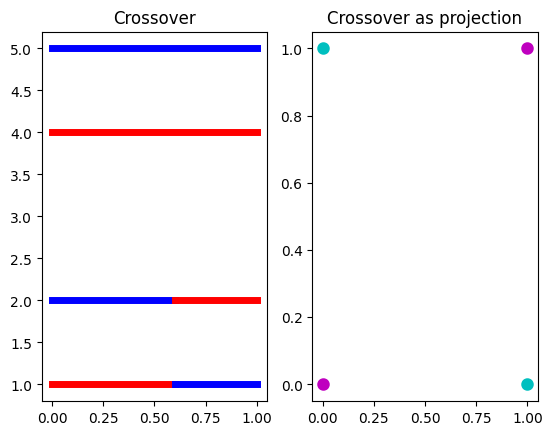

In [1]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Crossover")
fig=plt.plot((0, 1), (5, 5), linewidth=5, color='b')
fig=plt.plot((0, 1), (4, 4), linewidth=5, color='r')
fig=plt.plot((0, 0.6), (2, 2), linewidth=5, color='b')
fig=plt.plot((0, 0.6), (1, 1), linewidth=5, color='r')
fig=plt.plot((0.6, 1), (1, 1), linewidth=5, color='b')
fig=plt.plot((0.6, 1), (2, 2), linewidth=5, color='r')

plt.subplot(1,2,2)
plt.scatter([0, 1], [0,1], color='m', lw=3)
plt.scatter([1, 0], [0,1], color='c', lw=3)
plt.title("Crossover as projection")

plt.show()

# One Max Problem
This example will help new users to overview some of the DEAP framework’s possibilities and illustrate the potential of evolutionary algorithms in general. The problem itself is both very simple and widely used in the evolutionary computational community. We will create a population of individuals consisting of integer vectors randomly filled with 0 and 1. Then we let our population evolve until one of its members contains only 1 and no 0 anymore.


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

from deap import base
from deap import creator
from deap import tools

## Creator
Since the actual structure of the required individuals in genetic algorithms does strongly depend on the task at hand, DEAP does not contain any explicit structure. It will rather provide a convenient method for creating containers of attributes, associated with fitnesses, called the deap.creator. Using this method we can create custom individuals in a very simple way.

The creator is a class factory that can build new classes at run-time. It will be called with first the desired name of the new class, second the base class it will inherit, and in addition any subsequent arguments you want to become attributes of your class. This allows us to build new and complex structures of any type of container from lists to n-ary trees.

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

First we will define the class FitnessMax. It will inherit the Fitness class of the deap.base module and contain an additional attribute called weights. Please mind the value of weights to be the tuple (1.0,). This way we will be maximizing a single objective fitness. We can’t repeat it enough, in DEAP single objectives is a special case of multi objectives.

Next we will create the class Individual, which will inherit the class list and contain our previously defined FitnessMax class in its fitness attribute. Note that upon creation all our defined classes will be part of the creator container and can be called directly.

## Toolbox
Now we will use our custom classes to create types representing our individuals as well as our whole population.

All the objects we will use on our way, an individual, the population, as well as all functions, operators, and arguments will be stored in a DEAP container called Toolbox. It contains two methods for adding and removing content, register() and unregister().

In [23]:
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In this code block we register a generation function toolbox.attr_bool() and two initialization ones individual() and population(). toolbox.attr_bool(), when called, will draw a random integer between 0 and 1. The two initializers, on the other hand, will instantiate an individual or population.

The registration of the tools to the toolbox only associates aliases to the already existing functions and freezes part of their arguments. This allows us to fix an arbitrary amount of argument at certain values so we only have to specify the remaining ones when calling the method. For example, the attr_bool() generator is made from the randint() function that takes two arguments a and b, with a <= n <= b, where n is the returned integer. Here, we fix a = 0 and b = 1.

Our individuals will be generated using the function initRepeat(). Its first argument is a container class, in our example the Individual one we defined in the previous section. This container will be filled using the method attr_bool(), provided as second argument, and will contain 100 integers, as specified using the third argument. When called, the individual() method will thus return an individual initialized with what would be returned by calling the attr_bool() method 100 times. Finally, the population() method uses the same paradigm, but we don’t fix the number of individuals that it should contain.

## The Evaluation Function
The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.

In [24]:
def evalOneMax(individual):
    return sum(individual),
  
print(evalOneMax([0,0,0,0]))
print(evalOneMax([0,1,0,1]))
print(evalOneMax([1,1,1,1]))


(0,)
(2,)
(4,)


## The Genetic Operators
Within DEAP there are two ways of using operators. We can either simply call a function from the tools module or register it with its arguments in a toolbox, as we have already seen for our initialization methods. The most convenient way, however, is to register them in the toolbox, because this allows us to easily switch between the operators if desired. The toolbox method is also used when working with the algorithms module. See the [One Max Problem: Short Version](https://deap.readthedocs.io/en/master/examples/ga_onemax_short.html#short-ga-onemax) for an example.

Registering the genetic operators required for the evolution in our One Max problem and their default arguments in the toolbox is done as follows.

In [25]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

The evaluation will be performed by calling the alias evaluate. It is important to not fix its argument in here. We will need it later on to apply the function to each separate individual in our population. The mutation, on the other hand, needs an argument to be fixed (the independent probability of each attribute to be mutated indpb).

## Evolving the Population
Once the representation and the genetic operators are chosen, we will define an algorithm combining all the individual parts and performing the evolution of our population until the One Max problem is solved.

## Creating the Population
First of all, we need to actually instantiate our population. But this step is effortlessly done using the population() method we registered in our toolbox earlier on.

In [26]:
pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


**pop** will be a list composed of 300 individuals. Since we left the parameter **n** open during the registration of the population() method in our toolbox, we are free to create populations of arbitrary size.

Before we go on, this is the time to define some constants we will use later on.

In [27]:
# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

## Evaluating the Population
The next thing to do is to evaluate our brand new population.  We map() the evaluation function to every individual and then assign their respective fitness. Note that the order in fitnesses and population is the same.

The evolution of the population is the final step we have to accomplish. Recall, our individuals consist of 100 integer numbers and we want to evolve our population until we got at least one individual consisting of only 1s and no 0s. So all we have to do is to obtain the fitness values of the individuals!

To check the performance of the evolution, we will calculate and print the minimal, maximal, and mean values of the fitnesses of all individuals in our population as well as their standard deviations.

In [28]:
def findFitness():
    fits = [ind.fitness.values[0] for ind in pop]
        
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    return fits
    
fits=findFitness()

  Min 37.0
  Max 62.0
  Avg 49.91
  Std 5.000856593291525


## Mating and Mutation

In genetic algorithms, evolution occurs via either mutation or crossover, both of which happen (or don't happen) randomly.  In mutation, we change one or more of the genes of one of our individuals.  In cross-over, two individuals are mated to mix their genes.

The crossover (or mating) and mutation operators, provided within DEAP, usually take respectively 2 or 1 individual(s) as input and return 2 or 1 modified individual(s). In addition they modify those individuals within the toolbox container and we do not need to reassign their results.

We will perform both the crossover (mating) and the mutation of the produced children with a certain probability of CXPB and MUTPB. The del statement will invalidate the fitness of the modified offspring.

In [29]:
def mateAndMutate(offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            


## The Main Loop

This will creates an offspring list, which is an exact copy of the selected individuals. The toolbox.clone() method ensure that we don’t use a reference to the individuals but an completely independent instance. This is of utter importance since the genetic operators in toolbox will modify the provided objects in-place.

We then mutate and mate the individuals to find the next generation of individuals.  We evaluate them, and continue until one of our individuals evolves to be the perfect organism (fitness of 100 or more), or until the number of generations reaches 1000.

At each generation, we output some statistics about that generation's population, as well as a graph of the genetic material for an arbitrary individual.  A 0 in the genetic material is drawn in red, and a 1 is drawn in blue.

In [ ]:
import numpy as np
# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 100 and g < 1000:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation on the offspring
    mateAndMutate(offspring)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop[:] = offspring
    
    # print statistics on our updated population
    fits=findFitness()

    best_pop = pop[np.argmax(fits)]

    # plot the best organism
    x = [i/100 for i in range(len(best_pop))]
    y = [1 for i in x]
    colors = ['r' if best_pop[i]==0 else 'b' for i in range(len(best_pop))]
    plt.scatter(x, y, c=colors, alpha=0.5)
    plt.show()
plt.scatter(x,y, c=colors, alpha=.5)
plt.show()

# Your tasks:
This lab *is* fairly open-ended. I look forward to seeing what you come up with:

## 1. Find optimum with ES.
Chose an [artificial landscape](https://en.wikipedia.org/wiki/Test_functions_for_optimization). Find optimum using an evolutionary strategy we talked about in class.

In [2]:
# Goldstein–Price function is my evaluation function
# f(x,y) = [1+(x+y+1)**2 * (19-14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)] * [30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)]
def Goldstein_Price(individual: list):
    x = individual[0]
    y = individual[1]
    gold_value = (1+(x+y+1)**2 * (19-14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
            (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return (gold_value, )

Goldstein_Price([0,-1])

(3,)

In [161]:
# Tried also with different function
def rosenbrock_function(individual):
    return ((1-individual[0])**2 + 100*(individual[1]-individual[0]**2)**2,)

Visualization of the function

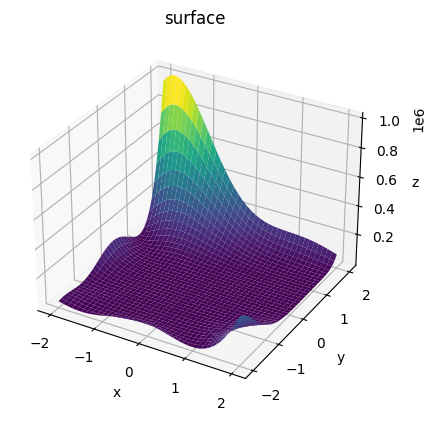

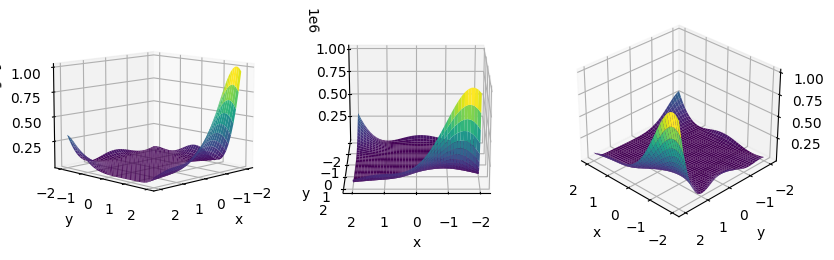

In [170]:
x = np.linspace(-2, 2, 40)
y = np.linspace(-2, 2, 40)

X, Y = np.meshgrid(x, y)
Z = Goldstein_Price((X,Y))
# Z = rosenbrock_function((X,Y))
Z = np.array(Z[0])

# Plot a single big plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_title('surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Plot 3 different angles
fig = plt.figure(figsize=plt.figaspect(0.5))
for i in range(1,4):
    ax = fig.add_subplot(1, 3, i, projection='3d')

    ax.view_init(i*10, i*45)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


Create Classes and methods

In [172]:
# Fitness to minimise -> negative weights means that my BEST will be the lowest
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# Individuals have two values (x,y) in a list structure
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# Attribute generator inside domain [-2, 2]
toolbox.register("pickValue", random.uniform, -2.0, 2.0)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.pickValue, 2)
# Population has an empty parameter for number of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [173]:
# CXPB -> probability with which two individuals are crossed
# MUTPB_IND -> probability for mutating an individual
# MUTPB_ATT -> probability for mutating an attribute of an individual
CXPB, MUTPB_IND, MUTPB_ATT = 0.5, 0.2, 0.4

toolbox.register("evaluate", Goldstein_Price)
toolbox.register("mate", tools.cxTwoPoint)  # Free parameters ind1, ind2
toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma = 1, indpb=MUTPB_ATT) # Free parameter individual
toolbox.register("select", tools.selBest)  # Free parameters individuals and k

In [174]:
# Evaluate
def evaluate(pop):
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

def findFitness():
    fits = [ind.fitness.values[0] for ind in pop]
    return fits

def printStatistics(fits):
    length = len(fits)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

# Selection
def createOffSpring(pop):
    # Select the next generation individuals
    offspring = toolbox.select(pop, int(len(pop)/3))
    offspring = offspring*3
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    return offspring

# Crossover and mutation
def mateAndMutate(offspring):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB_IND:
            toolbox.mutate(mutant)
            del mutant.fitness.values

Plot of the population

In [175]:
def plotPopulation(pop, fits):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    x = np.array([ind[0] for ind in pop])
    y = np.array([ind[1] for ind in pop])
    z = np.array(fits)

    ax.scatter3D(x, y, z, c=z, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')


Main evolution cycle

-- Initial population --
  Min 5.581370863293031
  Max 800646.810286474
  Avg 72968.88283353763
  Std 144922.94775164942
-- Final population --
  Min 3.000984239441204
  Max 1126640.354273736
  Avg 15449.404665355263
  Std 115921.73234489412
Best individual found in [0.0018623570962005816, -0.9988447009931293] after 213 epochs


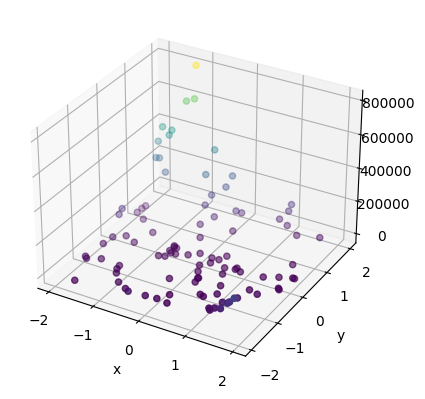

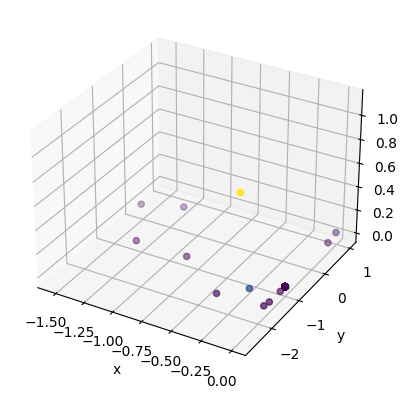

In [176]:
# Base Generation
pop = toolbox.population(n=100)
evaluate(pop)
fits=findFitness()
print("-- Initial population --")
printStatistics(fits)
plotPopulation(pop, fits)

# Variable keeping track of the number of generations
g = 0
# Begin the evolution
while min(fits) > 3.001 and g < 1000:
    g = g + 1
    offspring = createOffSpring(pop)
    # Apply crossover and mutation on the offspring
    mateAndMutate(offspring)
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    evaluate(invalid_ind)
    pop = offspring
    
    fits=findFitness()

print("-- Final population --")
printStatistics(fits)
best_ind = pop[np.argmin(fits)]
print("Best individual found in", best_ind, "after", g, "epochs")
plotPopulation(pop, fits)

## 2. Evolve a simple gaming neural net with GA.
Evolve a neural network that plays a game of your choice from `gym` (LunarLander-v2 is cool).
We don't need `torch` since we don't care about gradients. We can use numpy—numpy matrices can easily be multiplied.
`deap` *can* deal with numpy arrays, though I recommend making functions that map weights to lists and vice versa.

In [13]:
import numpy as np
from tqdm import tqdm
import gym, time

Create the basic structure of the model

In [14]:
from typing import Iterable

def relu(x):
    return x * (x > 0)

class DenseLayer:
    def __init__(self, w: list, b: list):
        self.weights = np.array(w, dtype = float)
        self.num_of_w = len(self.weights.flatten())

        self.bias = np.array(b, dtype=float)
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)
    
    def parameters(self) -> np.ndarray:
        """Returns all the vars of the layer (weights + biases) as a single ndarray"""
        t = np.append(self.weights, self.bias)
        return t.flatten()

    def forward(self, x: np.ndarray) -> np.ndarray:
        return (x @ self.weights) + self.bias

class Model():
    def __init__(self, params: Iterable):
        '''Initialize the model from an Iterable that goes over the parameters in order w1 -> b1 -> w2 -> b2 -> w3 -> b3'''
        w1 = next(params)
        b1 = next(params)
        w2 = next(params)
        b2 = next(params)
        w3 = next(params)
        b3 = next(params)
        if len(w1[0]) != len(b1) or len(w1[0]) != len(w2) or len(w2[0]) != len(b2) or len(w2[0]) != len(w3) or len(w3[0]) != len(b3):
            raise Exception("The dimensions of the layers are wrong")
        # save layers
        self.layer1 = DenseLayer(w1,b1)
        self.layer2 = DenseLayer(w2,b2)
        self.layer3 = DenseLayer(w3,b3)
        # Set variables useful for build model from param list
        start1 = len(self.layer1.parameters())
        self.starts = [0, start1 , start1 + len(self.layer2.parameters())]
 
    def __repr__(self):    
        return 'Layer1: ' + repr(self.layer1) + '\nLayer2: ' + repr(self.layer2) + '\nLayer3: ' + repr(self.layer3)

    def parameters(self) -> np.ndarray:
        """Returns all the vars of the layer (weights + biases) as a single ndarray"""
        t = np.append(self.layer1.parameters(), self.layer2.parameters())
        t = np.append(t, self.layer3.parameters())
        return t.flatten()

    # x is a matrix of integer or float numbers
    def forward(self, x:list):
        x = np.array(x)
        # send x through the network
        x = self.layer1.forward(x)
        x = relu(x)
        x = self.layer2.forward(x)
        x = relu(x)
        x = self.layer3.forward(x)
        
        return x

    def predictBestAction(self, observation):
        x = self.forward(observation)     # send x through neural net
        return np.argmax(x)               # predict the best action

    def updatedParams(self, params: list):
        '''Update model params from a plain list of parameters, the list should contain in order w1, b1, w2, b2, ...'''
        layers = [self.layer1, self.layer2, self.layer3]
        for layer, start in zip(layers, self.starts):
            end_w = start + layer.num_of_w
            list_weights = params[start:end_w]
            layer.weights = np.reshape(list_weights, newshape=layer.weights.shape)
            layer.bias = params[end_w: end_w + len(layer.bias)]


Evaluation function

In [15]:
def playGames(env, n, model: Model):
    '''Return average reward over n games'''
    tot_reward = 0
    for _ in range(n):
        state, _ = env.reset()
        done = False
        step = 0
        while not done and step < 500:
            step += 1
            # Make a move in game
            action = model.predictBestAction(state)
            new_state, reward, done, _, _ = env.step(action)
            # Update state
            state = new_state
            tot_reward += reward
    return (tot_reward / n,)

Setup deap

In [16]:
observation_dim = 8
action_dim = 4
# Create environment to test the models
env = gym.make('LunarLander-v2')

# Fitness to maximize
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individuals have a model with 3 layers (1 hidden layer), 6 parameters are necessary
creator.create("Individual", Model, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Attribute generator following gaussian distribution
toolbox.register("pickValue", random.gauss, 0, 1)

def initWeight(input, output):
    '''Create a matrix of random values of shape (input,output)'''
    return [tools.initRepeat(list, toolbox.pickValue, n=output) for _ in range(input)]

# Structure initializers
toolbox.register("weight1", initWeight, observation_dim, 128)
toolbox.register("weight2", initWeight, 128, 128)
toolbox.register("weight3", initWeight, 128, action_dim)
toolbox.register("bias1", tools.initRepeat, list, toolbox.pickValue, n=128)
toolbox.register("bias2", tools.initRepeat, list, toolbox.pickValue, n=128)
toolbox.register("bias3", tools.initRepeat, list, toolbox.pickValue, n=action_dim)

toolbox.register("individual", tools.initCycle, creator.Individual, 
    [toolbox.weight1, toolbox.bias1,
      toolbox.weight2, toolbox.bias2,
       toolbox.weight3, toolbox.bias3
       ], 1)

# Population has an empty parameter for number of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# CXPB -> probability with which two individuals are crossed
# CXPB_ATT -> probability that a couple of attributes is swapped
# MUTPB_IND -> probability for mutating an individual
# MUTPB_ATT -> probability for mutating an attribute of an individual
CXPB, CXPB_ATT, MUTPB_IND, MUTPB_ATT = 0.2, 0.05, 0.6, 0.1

# Evaluate the model over 3 games looking at his average reward
toolbox.register("evaluate", playGames, env, 3) # Free parameter model
toolbox.register("mate", tools.cxUniform, indpb=CXPB_ATT)  # Free parameters ind1, ind2
toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma = 1, indpb=MUTPB_ATT) # Free parameter individual
toolbox.register("select", tools.selTournament, tournsize=3)  # Free parameters individuals and k

Useful Methods

In [17]:
def evaluate(pop):
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

def findFitness():
    fits = [ind.fitness.values[0] for ind in pop]
    return fits

def printStatistics(fits):
    length = len(fits)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

# Selection
def createOffSpring(pop):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    return offspring

# Crossover and mutation
def mateAndMutate(offspring: list[Model]):
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            param1 = child1.parameters()
            param2 = child2.parameters()
            toolbox.mate(param1, param2)
            child1.updatedParams(param1)
            child2.updatedParams(param2)
            del child1.fitness.values
            del child2.fitness.values


    for mutant in offspring:
        if random.random() < MUTPB_IND:
            param = mutant.parameters()
            toolbox.mutate(param)
            mutant.updatedParams(param)
            del mutant.fitness.values

In [18]:
def show_performance(rewards):
    plt.plot(range(len(rewards)), rewards, "bo")
    plt.xlabel("Individual")
    plt.ylabel("Reward")
    plt.show()

def show_history(history_avg, history_max):
    epochs = range(len(history_avg))
    plt.plot(epochs, history_avg, color = "blue", label = "Average")
    plt.plot(epochs, history_max, color = "green", label = "Max")
    plt.xlabel("Epochs")
    plt.ylabel("Reward")
    plt.legend(loc="upper left")
    plt.show()

Main evolution cycle

In [ ]:
TRAIN = False

-- Initial population --
  Min -2580.883966855149
  Max -14.287747408451883
  Avg -527.9191043284935
  Std 365.20211492071786


 81%|████████  | 403/500 [3:01:28<43:40, 27.02s/it]  

-- Final population --
  Min -56.8811829019906
  Max 290.665194094043
  Avg 201.9101754146342
  Std 90.16443878544855
Best individual found after 403 epochs
Performance of the whole population ->


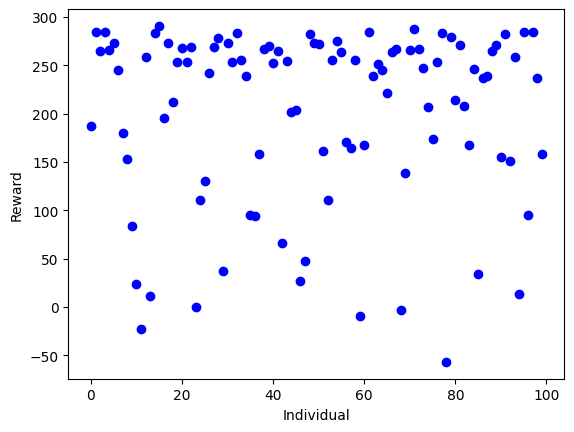

-- Progress:


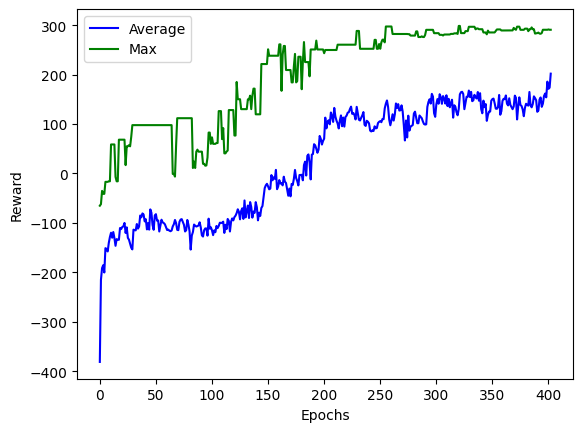

In [214]:
if TRAIN:
    # Base Generation
    pop = toolbox.population(n=100)
    evaluate(pop)
    fits=findFitness()
    print("-- Initial population --")
    printStatistics(fits)
    history_avg = []
    history_max = []
    avg = 0
    # Begin the evolution
    for g in tqdm(range(500)):
        if avg > 200:
            break
        offspring = createOffSpring(pop)
        # Apply crossover and mutation on the offspring
        mateAndMutate(offspring)
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        evaluate(invalid_ind)
        pop = offspring
        
        fits=findFitness()
        # compute and save the average of the fitnesses
        avg = sum(fits)/len(fits)
        history_avg.append(avg)
        history_max.append(max(fits))


    print("-- Final population --")
    printStatistics(fits)
    print("Best individual found after", g, "epochs")
    print("Performance of the whole population ->")
    show_performance(fits)
    print("-- Progress:")
    show_history(history_avg, history_max)

Play with the trained model and show performance

In [216]:
if TRAIN:
    env = gym.make('LunarLander-v2', render_mode='human')
    reward = playGames(env, 3, pop[np.argmax(fits)])
    env.close()

    max(fits), reward

(290.665194094043, (254.11508774357938,))

Save the best model saving the parameters

In [220]:
if TRAIN:
    s = pop[np.argmax(fits)].parameters()
    np.savetxt('modelGA.txt', s)

Play with the saved model

In [21]:
param = np.loadtxt('modelGA.txt')
model: Model = toolbox.individual()
model.updatedParams(param)

env = gym.make('LunarLander-v2', render_mode='human')
reward = playGames(env, 3, model)
env.close()

reward

(259.50850567023537,)

## 3. Implement Hebbian Learning on AND and OR logic gates.
Make functions that given an input of the kind `[1,1,0]`, `[0,0,0]`, etc.:
1. Returns 1 if input is all ones, otherwise 0 (AND).
2. Returns 1 if at least one element is 1, otherwise 0 (OR).
3. Optional: XOR.

![](HebbWeightUpdation.jpg)

### Define the samples

In [45]:
# samples are organized [x1,x2,x3,y] where y is the expected value
AND_samples = [
     #   [0, 0, 0, 0],
        [0, 0, 1, 0],
     #   [0, 1, 0, 0],
        [0, 1, 1, 0],
     #   [1, 0, 0, 0],
        [1, 0, 1, 0],
     #   [1, 1, 0, 0],
        [1, 1, 1, 1]
    ]

OR_samples = [
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 1]
    ]

XOR_samples = [
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0]
    ]

### Hebbian Network

In [53]:
INIT_VALUE = 0
class Heb_Network():
    def __init__(self, n):
        self.n = n
        # 1. Set all weights to zero, wi = 0 for i=1 to n, and bias to zero.
        self.weights = np.array([INIT_VALUE]*n)
        self.bias = 0
        self.learning_rate = 1
    
    def forward(self, x):
        return self.weights@x # + self.bias

    def output(self, x):
        # if self.forward(x) > self.bias * self.n:
        if self.forward(x) > 0:
            return 1
        else: 
            return 0

    def neuronActivations(self, input):
        '''Return the values fired from each neuron in an array'''
        return input*self.weights 

    def normalize(self):
        tot = np.sum(self.weights)
        if tot>1:
            self.weights = np.array([w / tot for w in self.weights])

    def utility(self, signal):
        if signal > 0:
            return 1
        return -1

    def learn(self, input, target_output):
        input = np.array([self.utility(i) for i in input])
        target_output = self.utility(target_output)
        # input = np.array(input) # use this if you don't want to use utility function but directly the input
        weight_change = self.learning_rate * input * target_output

        self.weights += weight_change 
        self.bias += target_output
        # print("input: ", input)
        # print("output: ", target_output)
        # print(self.weights)
        # self.normalize() # Use it if I'm not changine the input to negative values to avoid exponental growth of weights

### Training

In [50]:
# n is the number of neurons in the layer / inputs
n = 3
def hebbian_learning(n, samples):
    assert(n == len(samples[0])-1)
    network = Heb_Network(n)

    # 2. For each input vector, S(input vector) : t(target output pair), repeat steps 3-5.
    for sample in samples:
        # 3. Set activations for input units with the input vector Xi = Si for i = 1 to n.
        input_vector = sample[0:n]
        # 4. Set the corresponding output value to the output neuron, i.e. y = t.
        # Now I'm faking that the neuron with this input showed this particular output, the right one
        y = sample[-1]
        # 5. Update weights and bias by applying Hebbian rule for all i = 1 to n:
        network.learn(input_vector, y)
    
    return network

Print results

In [69]:
def results(network, input):
    print("Input =",input)
    print("Output =",network.output(input))

In [73]:
AND_network = hebbian_learning(3,AND_samples)
print("--- AND ---")
results(AND_network, [1,1,1])

print()

OR_network = hebbian_learning(3,OR_samples)
print("--- OR ---")
results(OR_network, [1,1,1])

print()

XOR_network = hebbian_learning(3,XOR_samples)
print("--- XOR ---")
results(XOR_network, [1,1,1])

--- AND ---
Input = [1, 1, 1]
Output = 1

--- OR ---
Input = [1, 1, 1]
Output = 1

--- XOR ---
Input = [1, 1, 1]
Output = 0


## Optional (and awesome): Do Hebbian Learning over Reinforcement Learning for the Lunar Lander from gym (LunarLander-v2).
![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [34]:
# Your code